<a id='id_5'></a>
# План работы:

1) [Загрузка и предварительный анализ данных.](#id_1)

2) [Анализ и подготовка данных.](#id_2)

3) [Обучение моделей, проверка](#id_3)

4) [Вывод](#id_4)

<a id='id_1'></a>
# 1. Загрузка и предварительный анализ данных
[К оглавлению.](#id_5)

In [61]:
# Загрузим все необходимые данные
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adamax, Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')
internet.info()
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


Итак, мы имеем 5517 столбцов и 8 колонок, пропусков нет.\
Проанализируем все столбцы:\
__customerID__ - личный номер каждого пользователя, формат obj, без изменений\
__InternetService__ - формат подключения, через телефонную линию или оптоволокно. Насколько это для нас актуально? Возможно, формат подключения не имеет значения и ни на что не влияет. Уточнить.\
__OnlineSecurity__ - блокировка небезопасных сайтов, формат obj, без изменений\
__OnlineBackup__ - облачное хранилище, формат obj, без изменений\
__DeviceProtection__ - антивирус, формат obj, без изменений\
__TechSupport__ - выделенная линия тех. поддержки, формат obj, без изменений\
__StreamingTV__ и __StreamingMovies__ - стриминговое телевидение и каталог фильмов. Формат obj, без изменений. Интересно, но на тех строках, что мы видим - значения в обоих столбцах совпадают. Возможно, так идет во всех строках, проверить, если гипотеза верна - можно один из столбцов удалить, чтобы сократить время обучения и понизить шанс переобучения модели.

In [4]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
phone.info()
phone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


6361 строк и 2 столбца, пропусков нет.\
Количество строк отличается от предыдущего датасета, последующие датасеты будут еще больше, а значит при слиянии будут пропуски, которые нужно будет обрабатывать.\
__customerID__ - личный номер каждого пользователя, формат obj, без изменений\
__MultipleLines__ - возможность подключения телефонного аппарата к нескольким линиям одновременно. Формат obj, без изменений.

In [5]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
contract.info()
contract

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


Тут у нас хранится информация о контрактах. 7043 строк и 8 столбцов.\
__customerID__ - личный номер, без изменений\
__BeginDate__ - дата начала пользования услугами, формат obj, перевести в формат datetime.\
__EndDate__ - дата окончания пользования услугами, формат obj, перевести в формат datetime. Для нас этот столбец является целевым признаком (если дата окончания указана - значит пользователь прекратил пользоваться нашими услугами). Будет удобнее создать отдельный столбец "Client", который будет обозначать является ли пользователь клиентом на данный момент или уже нет. Так же следует создать отдельный столбец, который посчитает сколько времени ушедший пользователь являлся нашим клиентом (для анализа это должно быть важно, быть может не задерживаются новенькие, а старички всем довольны и не спешат уходить?)\
__Type__ - тип оплаты (Ежемесячно, раз в несколько лет...). Формат obj, без изменений\
__PaperlessBilling__ - безбумажное выставление счетов, формат obj, без изменений. Возможно - это не самое важное и сильно на результат не влияет, уточнить... \
__PaymentMethod__ - способ облаты, формат obj, без изменений.\
__MonthlyCharges__ - ежемесячные платежи, формат float, без изменений. Уделить побольше внимания (из того что видно прямо сейчас - люди, с ежемесячной оплатой больше 50 и при ежемесячных платежах - прекратили пользоваться услугами, в то время как при годовалой или более оплате - до сих пор наши клиенты).\
__TotalCharges__ - сумма всех платежей, формат obj - поменять на float. 

In [6]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')
personal.info()
personal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


Строк, как и  предыдущем - 7043, но тут 5 колонок.\
__CustomerID__ - уникальный номер\
__gender__ - пол, формат obj, без изменений - насколько важен этот столбец? Возможно, будет лишним, уточнить\
__SeniorCitizen__ - является ли пенсионером или нет, формат инт - не понадобится энкодинг, удобно\
__Partner__ - наличие партнера (супруга/супруги). Формат obj, без изменений\
__Dependents__ - наличие иждевенцев, формат obj, без изменений

In [7]:
# Создадим общий датафрейм
data = internet.merge(phone, on='customerID', how='outer').merge(personal, on='customerID', how='outer').merge(contract, on='customerID', how='outer')
data

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,NaN,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,NaN,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4807-IZYOZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Female,0,No,No,2015-11-01,No,Two year,No,Bank transfer (automatic),20.65,1020.75
7039,9710-NJERN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Female,0,No,No,2016-11-01,No,Two year,No,Mailed check,20.15,826
7040,9837-FWLCH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Male,0,Yes,Yes,2019-02-01,No,Month-to-month,Yes,Electronic check,19.20,239
7041,0871-OPBXW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Female,0,No,No,2019-12-01,No,Month-to-month,Yes,Mailed check,20.05,39.25


In [8]:
# заполним пропуски
data = data.fillna('Not Used')
data

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,Not Used,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,Not Used,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4807-IZYOZ,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Female,0,No,No,2015-11-01,No,Two year,No,Bank transfer (automatic),20.65,1020.75
7039,9710-NJERN,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Female,0,No,No,2016-11-01,No,Two year,No,Mailed check,20.15,826
7040,9837-FWLCH,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Male,0,Yes,Yes,2019-02-01,No,Month-to-month,Yes,Electronic check,19.20,239
7041,0871-OPBXW,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Female,0,No,No,2019-12-01,No,Month-to-month,Yes,Mailed check,20.05,39.25


In [9]:
# Выведем в отдельный столбец - является ли пользователь клиентом на настоящее время
def check_users(data):
    for rows in data:
        time = data['EndDate']
        
        if time == 'No':
            return 1
        else:
            return 0
data['Client'] = data.apply(check_users, axis = 1)
data

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,...,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Client
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,Not Used,Female,...,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No,Male,...,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,1
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No,Male,...,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,0
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,Not Used,Male,...,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,1
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,No,Female,...,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4807-IZYOZ,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Female,...,No,No,2015-11-01,No,Two year,No,Bank transfer (automatic),20.65,1020.75,1
7039,9710-NJERN,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Female,...,No,No,2016-11-01,No,Two year,No,Mailed check,20.15,826,1
7040,9837-FWLCH,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Male,...,Yes,Yes,2019-02-01,No,Month-to-month,Yes,Electronic check,19.20,239,1
7041,0871-OPBXW,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Female,...,No,No,2019-12-01,No,Month-to-month,Yes,Mailed check,20.05,39.25,1


In [10]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
MultipleLines       7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Client              7043 non-null int64
dtypes: float64(1), int64(2), obj

In [11]:
# Отлично, теперь все наши клиенты имеют значение 1 в столбце Client, бегунки же имеют значение 0
# Теперь посчитаем время пользования нашими услугами

data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y.%m.%d')
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y.%m.%d')
data['Time_used'] = data['EndDate'] - data['BeginDate']
data['Time_used'] = pd.to_numeric(data['Time_used'].dt.days, downcast='integer')
data

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,...,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Client,Time_used
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,Not Used,Female,...,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,1,31
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No,Male,...,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,1,1036
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No,Male,...,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0,61
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,Not Used,Male,...,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1,1371
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,No,Female,...,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4807-IZYOZ,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Female,...,No,2015-11-01,2020-02-01,Two year,No,Bank transfer (automatic),20.65,1020.75,1,1553
7039,9710-NJERN,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Female,...,No,2016-11-01,2020-02-01,Two year,No,Mailed check,20.15,826,1,1187
7040,9837-FWLCH,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Male,...,Yes,2019-02-01,2020-02-01,Month-to-month,Yes,Electronic check,19.20,239,1,365
7041,0871-OPBXW,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,No,Female,...,No,2019-12-01,2020-02-01,Month-to-month,Yes,Mailed check,20.05,39.25,1,62


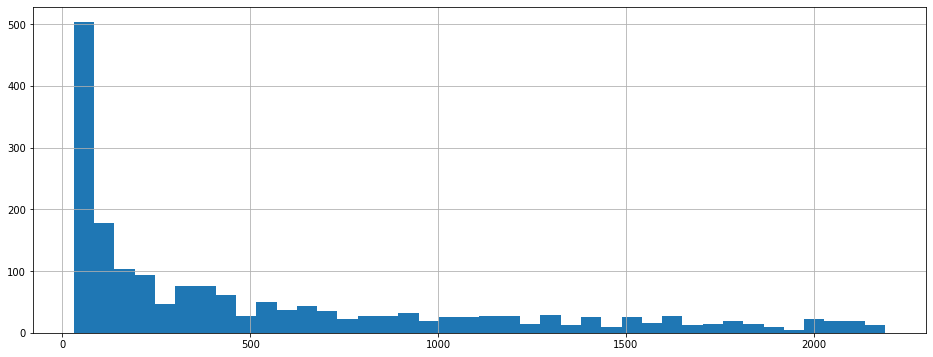

In [12]:
# Создадим отдельный датафрейм только с клиентами, которые отказались от наших услуг
data_out = data.query('Client == 0')
data_out['Time_used'].hist(figsize=(16,6), bins=40)

Большая часть бегунков - люди, которые были у нас месяц-два. Т.е. люди начинают пользоваться, спустя месяц-два уходят, а значит, проблема возможна не только в цене, но людей так же может неустраивать качество или сервисы.

In [13]:
# Оценим датафрейм с отказавшимися от услуг клиентами
data_out.describe()

,SeniorCitizen,MonthlyCharges,Client,Time_used
count,1869.000000,1869.000000,1869.0,1869.000000
mean,0.254682,74.441332,0.0,547.352060
std,0.435799,24.666053,0.0,594.389607
min,0.000000,18.850000,0.0,30.000000
25%,0.000000,56.150000,0.0,61.000000
50%,0.000000,79.650000,0.0,304.000000
75%,1.000000,94.200000,0.0,883.000000
max,1.000000,118.350000,0.0,2191.000000


1869 клиентов ушло (из 7043). Средняя оплата -74,44, медиана - 79,65

In [14]:
# По аналогии с предыдущим датафреймом - отдельно промониторим тех клиентов, что остались у нас
data_in = data.query('Client == 1')
data_in.describe()

,SeniorCitizen,MonthlyCharges,Client,Time_used
count,5174.000000,5174.000000,5174.0,5174.000000
mean,0.128721,61.265124,1.0,1144.447236
std,0.334923,31.092648,0.0,733.897937
min,0.000000,18.250000,1.0,0.000000
25%,0.000000,25.100000,1.0,457.000000
50%,0.000000,64.425000,1.0,1157.000000
75%,0.000000,88.400000,1.0,1857.000000
max,1.000000,118.750000,1.0,2191.000000


Среди тех, кто остался у нас : средняя оплата - 61,26, медиана - 64,42 (что почти на 20% меньше чем у тех, кто уходил).

#### Итак, предварительный анализ завершен, время приступить к более глубокому анализу и обработке.

<a id='id_2'></a>
# 2. Графический анализ и подготовка данных.
[К оглавлению.](#id_5)

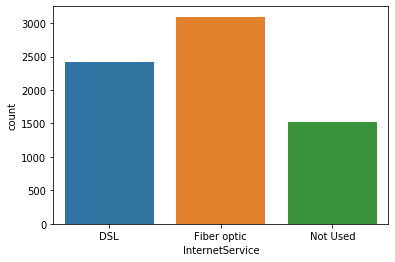

In [15]:
# Посмотрим на примере столбца InternetService - есть ли какие-либо закономерности в том, как были подключены ушедшие клиенты.
# Для начала построим график на общем датасете
sns.countplot(x=data['InternetService'])

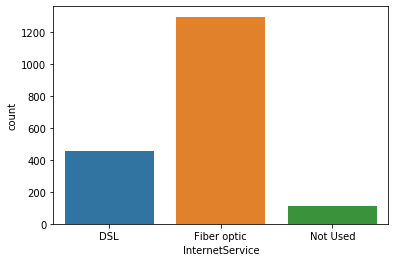

In [16]:
# Теперь сравним с данными только по покинувшим нашу фирму клиентам
sns.countplot(x=data_out['InternetService'])

In [17]:
# Напишем функцию, которая позволит нам автоматизировать построение графиков
def print_sns(list_of_columns):
    for columns in list_of_columns:

        plt.figure(figsize=(10,5))
        sns.countplot(x=data[columns].sort_values())
        plt.title("Общее количество")
        plt.show()
        sns.countplot(x=data_out[columns].sort_values()) 
        plt.title('Ушедшие')
        plt.show()
        sns.countplot(x=data_in[columns].sort_values())
        plt.title('Абоненты')
        plt.show()

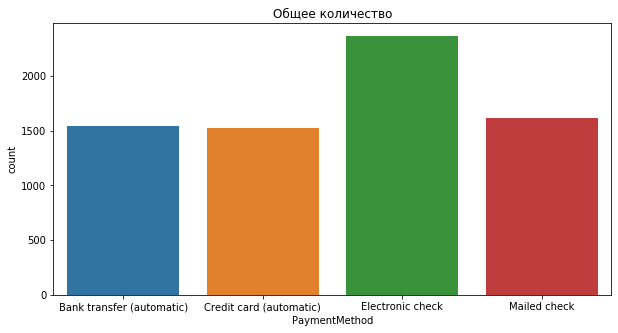

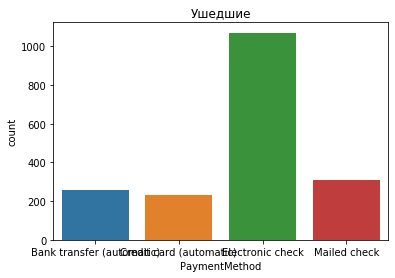

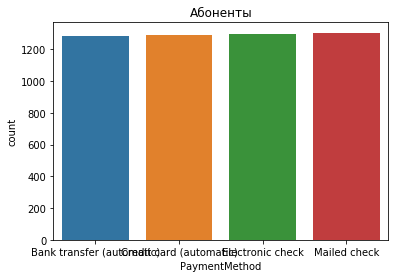

In [18]:
# Попробуем проанализировать другие столбцы

print_sns(['PaymentMethod'])

Интересное распределение. Изначально лидировали абоненты с электронным чеком, после чего в этой группе случился сильный отток, а на данный момент - распределение равномерное. Быть может, были какие-то проблемы с рассылкой электронных чеков?

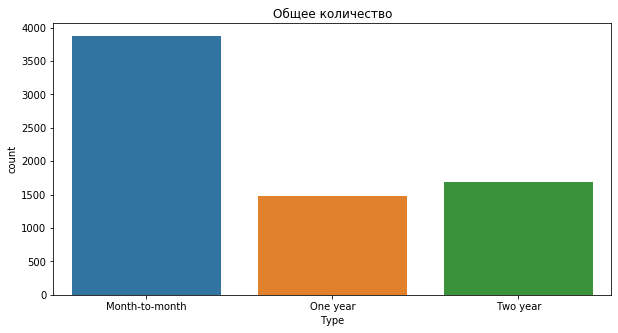

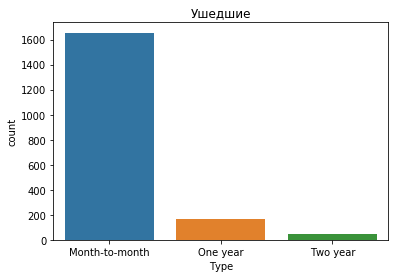

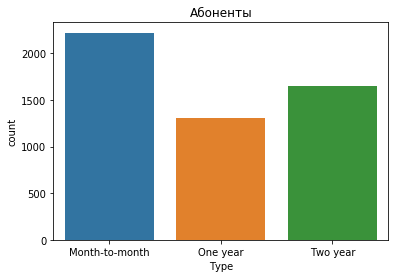

In [19]:
print_sns(['Type'])

В зоне риска - ежемесячные платежи, что вполне логично

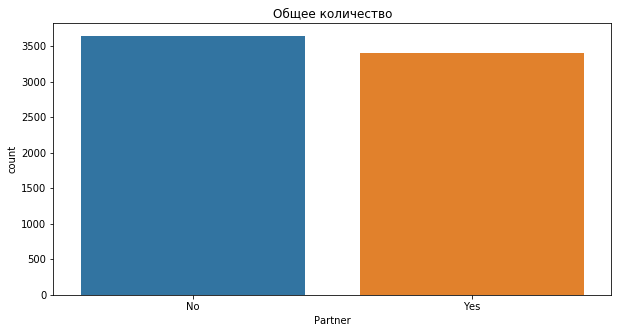

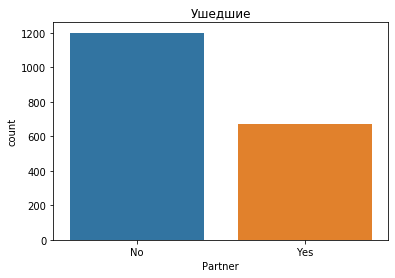

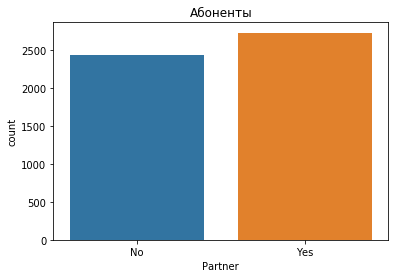

In [20]:
print_sns(['Partner'])

Люди без брака - уходят чаще. Возможно, они не так привязаны к месту жительства, больше путешествуют, либо в какой-то момент играют брак и вместо 2 отдельных пользователей - появляется один. Причин может быть много, но разница не сильно критичная.

In [21]:
data = data.drop(columns=['customerID', 'BeginDate', 'EndDate'])
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
MultipleLines       7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Client              7043 non-null int64
Time_used           7043 non-null int16
dtypes: float64(2), int16(1), int64(2), object(14)
memory usage: 1.3+ MB


In [22]:
# Есть 11 строк с незполненными данными, потери не страшные, а значит удалим их
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
MultipleLines       7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Client              7032 non-null int64
Time_used           7032 non-null int16
dtypes: float64(2), int16(1), int64(2), object(14)
memory usage: 1.0+ MB


In [23]:
# Преобразуем формат в столбце SeniorCitizen
data1 = data
data['SeniorCitizen'] = data['SeniorCitizen'].astype(object)
data = pd.get_dummies(data, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 30 columns):
MonthlyCharges                           7032 non-null float64
TotalCharges                             7032 non-null float64
Client                                   7032 non-null int64
Time_used                                7032 non-null int16
InternetService_Fiber optic              7032 non-null uint8
InternetService_Not Used                 7032 non-null uint8
OnlineSecurity_Not Used                  7032 non-null uint8
OnlineSecurity_Yes                       7032 non-null uint8
OnlineBackup_Not Used                    7032 non-null uint8
OnlineBackup_Yes                         7032 non-null uint8
DeviceProtection_Not Used                7032 non-null uint8
DeviceProtection_Yes                     7032 non-null uint8
TechSupport_Not Used                     7032 non-null uint8
TechSupport_Yes                          7032 non-null uint8
StreamingTV_Not Used               

In [24]:
from sklearn.preprocessing import StandardScaler
numeric = ['MonthlyCharges', 'TotalCharges', 'Time_used']
scaler = StandardScaler()
scaler.fit(data[numeric])
data[numeric] = scaler.transform(data[numeric])
data

,MonthlyCharges,TotalCharges,Client,Time_used,InternetService_Fiber optic,InternetService_Not Used,OnlineSecurity_Not Used,OnlineSecurity_Yes,OnlineBackup_Not Used,OnlineBackup_Yes,...,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.161694,-0.994194,1,-1.280334,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
1,-0.260878,-0.173740,1,0.064866,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2,-0.363923,-0.959649,0,-1.240179,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0,1
3,-0.747850,-0.195248,1,0.513266,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0.196178,-0.940457,0,-1.240179,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-1.467506,-0.557021,1,0.756875,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7039,-1.484126,-0.642943,1,0.266981,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1
7040,-1.515705,-0.901920,1,-0.833273,0,1,1,0,1,0,...,1,0,1,1,0,0,1,0,1,0
7041,-1.487450,-0.990047,1,-1.238841,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [25]:
# Создадим обучающую выборку (60%), валидационную (20%) и тестовую (20%)
data_train, data_another = train_test_split(data, test_size = 0.4, random_state=111111)


In [26]:
data_valid, data_test = train_test_split(data_another, test_size = 0.5, random_state=111111)
features_train = data_train.drop(['Client'], axis=1)
target_train = data_train['Client']
features_valid = data_valid.drop(['Client'], axis=1)
target_valid = data_valid['Client']
features_test = data_test.drop(['Client'], axis=1)
target_test = data_test['Client']

In [27]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4219 entries, 271 to 1306
Data columns (total 29 columns):
MonthlyCharges                           4219 non-null float64
TotalCharges                             4219 non-null float64
Time_used                                4219 non-null float64
InternetService_Fiber optic              4219 non-null uint8
InternetService_Not Used                 4219 non-null uint8
OnlineSecurity_Not Used                  4219 non-null uint8
OnlineSecurity_Yes                       4219 non-null uint8
OnlineBackup_Not Used                    4219 non-null uint8
OnlineBackup_Yes                         4219 non-null uint8
DeviceProtection_Not Used                4219 non-null uint8
DeviceProtection_Yes                     4219 non-null uint8
TechSupport_Not Used                     4219 non-null uint8
TechSupport_Yes                          4219 non-null uint8
StreamingTV_Not Used                     4219 non-null uint8
StreamingTV_Yes                

#### Итак, анализ закончен, данные обработаны, использован энкодинг и нормализация данных, созданы 3 выборки, а значит можно приступить к обучению моделей

<a id='id_3'></a>
# 3. Обучение моделей
[К оглавлению.](#id_5)

### LGBMClassifier

In [28]:
for est in range (1, 62, 10):
    model=LGBMClassifier(n_estimators=est)
    model.fit(features_train, target_train)
    predict=model.predict(features_valid)
    roc_auc=roc_auc_score(target_valid, predict)
    accuracy = accuracy_score(target_valid, predict)
    print(est, '-', 'ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

1 - ROC_AUC -  0.5 , accuracy - 0.7610241820768137
11 - ROC_AUC -  0.6946957053849577 , accuracy - 0.8413940256045519
21 - ROC_AUC -  0.7229333555852248 , accuracy - 0.8470839260312945
31 - ROC_AUC -  0.7481085892300846 , accuracy - 0.852773826458037
41 - ROC_AUC -  0.7495966844681798 , accuracy - 0.8534850640113798
51 - ROC_AUC -  0.7561888072986203 , accuracy - 0.8541963015647226
61 - ROC_AUC -  0.7532988429016467 , accuracy - 0.8513513513513513


In [29]:
for depth in range (1, 11, 2):
    model=LGBMClassifier(n_estimators=61, max_depth=depth)
    model.fit(features_train, target_train)
    predict=model.predict(features_valid)
    roc_auc=roc_auc_score(target_valid, predict)
    accuracy = accuracy_score(target_valid, predict)
    print(depth, '-', 'ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

1 - ROC_AUC -  0.6609868713840676 , accuracy - 0.8165007112375533
3 - ROC_AUC -  0.7213228749443703 , accuracy - 0.8399715504978663
5 - ROC_AUC -  0.7325878949710725 , accuracy - 0.8477951635846372
7 - ROC_AUC -  0.7457721406319537 , accuracy - 0.8492176386913229
9 - ROC_AUC -  0.7459445927903873 , accuracy - 0.8463726884779517


In [30]:
# Параметры подобраны, проверим на тестовой выборке результаты
model = LGBMClassifier(n_estimators=61, max_depth=9)
model.fit(features_train, target_train)
predict=model.predict(features_test)
roc_auc = roc_auc_score(target_test, predict)
accuracy=accuracy_score(target_test, predict)
print('ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

ROC_AUC -  0.7737199165506209 , accuracy - 0.8493248045486852


#### ROC_AUC = 0.76, accuracy=0.84

### CatBoostClassifier

In [31]:
model=CatBoostClassifier(iterations=100, depth=5)
model.fit(features_train, target_train)
predict=model.predict(features_valid)
roc_auc=roc_auc_score(target_valid, predict)
accuracy = accuracy_score(target_valid, predict)
print('ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

Learning rate set to 0.195911
0:	learn: 0.5838539	total: 53.7ms	remaining: 5.31s
1:	learn: 0.5293648	total: 57.8ms	remaining: 2.83s
2:	learn: 0.4932915	total: 65.1ms	remaining: 2.1s
3:	learn: 0.4669436	total: 111ms	remaining: 2.65s
4:	learn: 0.4515965	total: 114ms	remaining: 2.17s
5:	learn: 0.4364857	total: 119ms	remaining: 1.86s
6:	learn: 0.4282623	total: 122ms	remaining: 1.62s
7:	learn: 0.4216266	total: 126ms	remaining: 1.45s
8:	learn: 0.4123768	total: 208ms	remaining: 2.1s
9:	learn: 0.4078889	total: 214ms	remaining: 1.93s
10:	learn: 0.4040987	total: 219ms	remaining: 1.77s
11:	learn: 0.3995950	total: 305ms	remaining: 2.23s
12:	learn: 0.3968216	total: 310ms	remaining: 2.07s
13:	learn: 0.3939919	total: 317ms	remaining: 1.95s
14:	learn: 0.3900813	total: 320ms	remaining: 1.81s
15:	learn: 0.3878839	total: 323ms	remaining: 1.7s
16:	learn: 0.3856254	total: 402ms	remaining: 1.96s
17:	learn: 0.3844946	total: 405ms	remaining: 1.85s
18:	learn: 0.3828729	total: 409ms	remaining: 1.74s
19:	learn: 

In [32]:
# Проверим на тестовой выборке
predict=model.predict(features_test)
roc_auc=roc_auc_score(target_test, predict)
accuracy = accuracy_score(target_test, predict)
print('ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

ROC_AUC -  0.7915370319561426 , accuracy - 0.8692253020611229


#### ROC_AUC -  0.77 , accuracy - 0.85, показатели опять высоки.

### DecisionTreeClassifier

In [33]:
for depth in range(1, 16, 2):
    
    model = DecisionTreeClassifier(max_depth=depth, random_state=123)
    model.fit(features_train, target_train)
    predict=model.predict(features_valid)
    roc_auc=roc_auc_score(target_valid, predict)
    accuracy = accuracy_score(target_valid, predict)
    print(depth, '-', 'ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

1 - ROC_AUC -  0.5 , accuracy - 0.7610241820768137
3 - ROC_AUC -  0.6791889185580775 , accuracy - 0.8193456614509246
5 - ROC_AUC -  0.6842428793947486 , accuracy - 0.8285917496443812
7 - ROC_AUC -  0.7347296395193592 , accuracy - 0.829302987197724
9 - ROC_AUC -  0.7080301513128615 , accuracy - 0.8150782361308677
11 - ROC_AUC -  0.7101218291054741 , accuracy - 0.8058321479374111
13 - ROC_AUC -  0.6927959501557633 , accuracy - 0.7716927453769559
15 - ROC_AUC -  0.6887627948375613 , accuracy - 0.7624466571834992


In [34]:
for split in range(2, 10, 1):

    model = DecisionTreeClassifier(max_depth=15, random_state=123, min_samples_split=split)
    model.fit(features_train, target_train)
    predict=model.predict(features_valid)
    roc_auc=roc_auc_score(target_valid, predict)
    accuracy = accuracy_score(target_valid, predict)
    print(split, '-', 'ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

2 - ROC_AUC -  0.6887627948375613 , accuracy - 0.7624466571834992
3 - ROC_AUC -  0.6829828660436138 , accuracy - 0.7567567567567568
4 - ROC_AUC -  0.6846434134401425 , accuracy - 0.7546230440967283
5 - ROC_AUC -  0.688849020916778 , accuracy - 0.7610241820768137
6 - ROC_AUC -  0.6901646639964397 , accuracy - 0.7645803698435277
7 - ROC_AUC -  0.6936081441922564 , accuracy - 0.7667140825035562
8 - ROC_AUC -  0.691652759234535 , accuracy - 0.7652916073968705
9 - ROC_AUC -  0.7001140409434801 , accuracy - 0.7688477951635846


In [35]:
model = DecisionTreeClassifier(max_depth=15, random_state=123, min_samples_split=2)
model.fit(features_train, target_train)
predict=model.predict(features_test)
roc_auc=roc_auc_score(target_test, predict)
accuracy = accuracy_score(target_test, predict)
print('ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

ROC_AUC -  0.7042956758519654 , accuracy - 0.7661691542288557


#### ROC_AUC -  0.71, accuracy - 0.77

### RandomForestClassifier

In [36]:
for depth in range(1, 160, 10):

    model = RandomForestClassifier(max_depth=depth, random_state=123)
    model.fit(features_train, target_train)
    predict=model.predict(features_valid)
    roc_auc=roc_auc_score(target_valid, predict)
    accuracy = accuracy_score(target_valid, predict)
    print(depth, '-', 'ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

1 - ROC_AUC -  0.5 , accuracy - 0.7610241820768137
11 - ROC_AUC -  0.7096406319537161 , accuracy - 0.8221906116642959
21 - ROC_AUC -  0.7174399198931909 , accuracy - 0.8029871977240398
31 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
41 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
51 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
61 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
71 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
81 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
91 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
101 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
111 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
121 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
131 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
141 - ROC_AUC -  0.7260736537605696 , accuracy - 0.8036984352773826
151 - 

In [37]:
for est in range (1, 1002, 50):

    model = RandomForestClassifier(max_depth=31, n_estimators=est, random_state=123)
    model.fit(features_train, target_train)
    predict=model.predict(features_valid)
    roc_auc=roc_auc_score(target_valid, predict)
    accuracy = accuracy_score(target_valid, predict)
    print(est, '-', 'ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

1 - ROC_AUC -  0.6469737427681354 , accuracy - 0.7361308677098151
51 - ROC_AUC -  0.7124944370271473 , accuracy - 0.8172119487908962
101 - ROC_AUC -  0.7107476635514018 , accuracy - 0.8207681365576103
151 - ROC_AUC -  0.7052625723186471 , accuracy - 0.8186344238975818
201 - ROC_AUC -  0.7038607031597686 , accuracy - 0.8165007112375533
251 - ROC_AUC -  0.7044142189586114 , accuracy - 0.8157894736842105
301 - ROC_AUC -  0.7034796395193592 , accuracy - 0.8143669985775249
351 - ROC_AUC -  0.6985480640854472 , accuracy - 0.8115220483641536
401 - ROC_AUC -  0.7049677347574543 , accuracy - 0.8150782361308677
451 - ROC_AUC -  0.7015242545616378 , accuracy - 0.8129445234708392
501 - ROC_AUC -  0.7034796395193592 , accuracy - 0.8143669985775249
551 - ROC_AUC -  0.7005034490431686 , accuracy - 0.8129445234708392
601 - ROC_AUC -  0.7024588340008902 , accuracy - 0.8143669985775249
651 - ROC_AUC -  0.6994826435246997 , accuracy - 0.8129445234708392
701 - ROC_AUC -  0.7004172229639519 , accuracy - 0.

In [86]:
model = RandomForestClassifier(max_depth=31, n_estimators=901, random_state=123)
model.fit(features_train, target_train)
predict=model.predict(features_test)
roc_auc=roc_auc_score(target_test, predict)
accuracy = accuracy_score(target_test, predict)
print('ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

ROC_AUC -  0.7438474201614116 , accuracy - 0.828002842928216


#### ROC_AUC -  0.71, accuracy - 0.81

In [87]:
features_important = model.feature_importances_
feat = pd.DataFrame(features_important, index=features_train.columns)
feat

,0
MonthlyCharges,0.157427
TotalCharges,0.187036
Time_used,0.209845
InternetService_Fiber optic,0.039351
InternetService_Not Used,0.005380
OnlineSecurity_Not Used,0.005636
OnlineSecurity_Yes,0.025293
OnlineBackup_Not Used,0.003977
OnlineBackup_Yes,0.020789
DeviceProtection_Not Used,0.004783


### LogisticRegression

In [48]:
model = LogisticRegression()
model.fit(features_train, target_train)
predict=model.predict(features_valid)
roc_auc=roc_auc_score(target_valid, predict)
accuracy = accuracy_score(target_valid, predict)
print('ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

ROC_AUC -  0.7185330440587451 , accuracy - 0.8186344238975818


In [49]:
predict=model.predict(features_test)
roc_auc=roc_auc_score(target_test, predict)
accuracy = accuracy_score(target_test, predict)
print('ROC_AUC - ', roc_auc, ', accuracy -', accuracy)

ROC_AUC -  0.7475125665860817 , accuracy - 0.8258706467661692


#### ROC_AUC -  0.70, accuracy - 0.80

### Нейронная Сеть

In [54]:
# Попробуем создать нейронную сеть

model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=29))
model.add(Dropout(0.5))

adam = Adamax(lr=0.0018)
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=adam,

              loss='binary_crossentropy',

              metrics=['AUC', 'acc'])
model.fit(features_train, target_train, epochs=10, batch_size=40)
predict = model.predict(features_valid)
roc_auc_score(target_valid, predict)

Train on 4219 samples
Epoch 1/10
4219/4219 [==============================] - 1s 351us/sample - loss: 0.4543 - AUC: 0.8155 - acc: 0.7774
Epoch 2/10
4219/4219 [==============================] - 1s 191us/sample - loss: 0.4366 - AUC: 0.8324 - acc: 0.7879
Epoch 3/10
4219/4219 [==============================] - 1s 187us/sample - loss: 0.4293 - AUC: 0.8392 - acc: 0.7905
Epoch 4/10
4219/4219 [==============================] - 1s 187us/sample - loss: 0.4294 - AUC: 0.8389 - acc: 0.7907
Epoch 5/10
4219/4219 [==============================] - 1s 173us/sample - loss: 0.4267 - AUC: 0.8417 - acc: 0.7936
Epoch 6/10
4219/4219 [==============================] - 1s 186us/sample - loss: 0.4230 - AUC: 0.8449 - acc: 0.7973
Epoch 7/10
4219/4219 [==============================] - 1s 187us/sample - loss: 0.4236 - AUC: 0.8449 - acc: 0.7964
Epoch 8/10
4219/4219 [==============================] - 1s 171us/sample - loss: 0.4208 - AUC: 0.8469 - acc: 0.7971
Epoch 9/10
4219/4219 [==============================] - 1s

0.8403607587894971

In [55]:
predict = model.predict(features_test)
roc_auc_score(target_test, predict)

0.8651842150219237

#### Показатели ROC_AUC 0.86%

<a id='id_4'></a>
# 4. Вывод
[К оглавлению.](#id_5)

In [43]:
# Для удобства - создадим датафрейм с общими выводами
results = {'ROC_AUC':[0.76, 0.77, 0.71, 0.71, 0.71, 0.86]}
index = ['LGBM', 'CatBoost', 'DecisionTree', 'RandomForest', 'LogisticRegression', 'NeuralNetwork']
all_results = pd.DataFrame(results, index=index)
all_results

,ROC_AUC
LGBM,0.76
CatBoost,0.77
DecisionTree,0.71
RandomForest,0.71
LogisticRegression,0.71
NeuralNetwork,0.86


Можно заметить, насколько же нейронная сеть преобладает по качеству и точности прогноза. Выбор падет именно на неё

In [139]:
# features_importances_ не работает при модели Sequential - поэтому как образец использую Случайный лес и древо решений
model = RandomForestClassifier(max_depth=31, n_estimators=901, random_state=123)
model.fit(features_train, target_train)

features_important = model.feature_importances_
feat = pd.DataFrame(features_important, index=features_train.columns)
feat

,0
MonthlyCharges,0.157427
TotalCharges,0.187036
Time_used,0.209845
InternetService_Fiber optic,0.039351
InternetService_Not Used,0.005380
OnlineSecurity_Not Used,0.005636
OnlineSecurity_Yes,0.025293
OnlineBackup_Not Used,0.003977
OnlineBackup_Yes,0.020789
DeviceProtection_Not Used,0.004783


In [147]:
model = DecisionTreeClassifier(max_depth=15, random_state=123, min_samples_split=2)
model.fit(features_train, target_train)
features_important = model.feature_importances_
feat2 = pd.DataFrame(features_important, index=features_train.columns)
feat2

,0
MonthlyCharges,0.158318
TotalCharges,0.160435
Time_used,0.356878
InternetService_Fiber optic,0.120104
InternetService_Not Used,0.000000
OnlineSecurity_Not Used,0.000000
OnlineSecurity_Yes,0.015222
OnlineBackup_Not Used,0.000000
OnlineBackup_Yes,0.009335
DeviceProtection_Not Used,0.000000


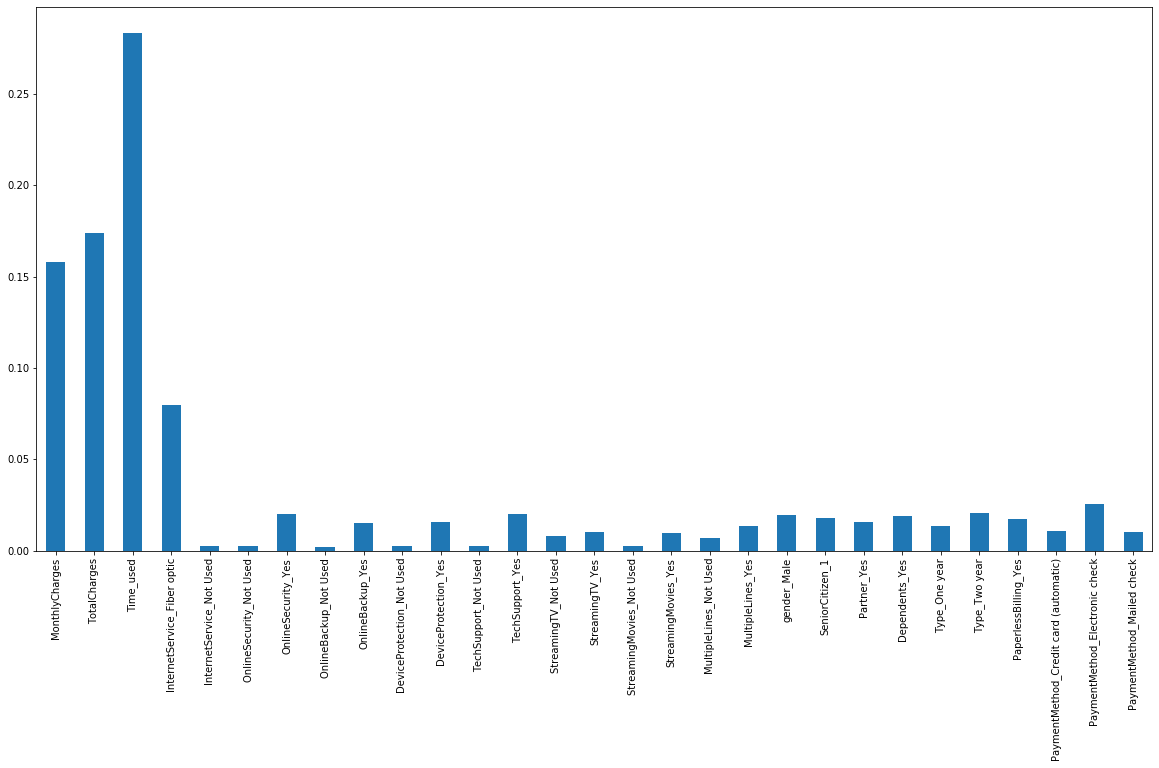

In [149]:
feat['mean_sum'] = (feat[0] + feat2[0])/2
feat['mean_sum'].plot(kind='bar', figsize=(20,10))

Самые важные признаки - численные, а именно: время использования, общая плата и месячная плата. Так же достаточно весомым оказался вид интернет-подключения.
Все остальные признаки влияют в меньшей мере, а некоторые вообще сильно на результат не влияют.

In [44]:
# Проверим корреляцию числовых столбцов. Для этого я заранее сделал резервный датафрейм data1, с которым не были произведены 
# стандартизация и энкодинг
data1.corr()

,MonthlyCharges,TotalCharges,Client,Time_used
MonthlyCharges,1.000000,0.651065,-0.192858,0.246715
TotalCharges,0.651065,1.000000,0.199484,0.825811
Client,-0.192858,0.199484,1.000000,0.354496
Time_used,0.246715,0.825811,0.354496,1.000000


Можно заметить, как сильно влияют друг на друга столбцы Time_used и TotalCharges (0.82). Что, в принципе, вполне логично, ведь чем дольше пользователь использует наши услуги - тем более он платит. Так же столбец TotalCharges сильно зависит от столбца MonthlyCharges (0.65). И, опять-таки, связь понятная - чем больше месячный платеж, тем больше и суммарные платежи. Для повыешния качества работы модели - попробуем удалить столбец TotalCharges.

In [45]:
data1 = data1.drop('TotalCharges', axis=1)
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
MultipleLines       7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
Client              7032 non-null int64
Time_used           7032 non-null int16
dtypes: float64(1), int16(1), int64(1), object(15)
memory usage: 1002.6+ KB


In [157]:
# Теперь напишем функции, которые будут исследовать - есть ли интернет или телефон
def check_internet(data):
    for rows in data:
        if data['InternetService'] != 'NotUsed':
            return 1
        else:
            return 0
        
def check_phone(data):
    for rows in data:
        if data['MultipleLines'] != 'NotUsed':
            return 1
        else:
            return 0

def sum_services(data):
    for rows in data:
        total = 0
        if data['OnlineSecurity'] == 'Yes':
            total += 1
        
        if data['OnlineBackup'] == 'Yes':
            total += 1
        if data['DeviceProtection'] == 'Yes':
            total += 1  
        if data['TechSupport'] == 'Yes':
            total += 1
        if data['StreamingTV'] == 'Yes':
            total += 1            
        if data['StreamingMovies'] == 'Yes':
            total += 1            
        if data['MultipleLines'] == 'Yes':
            total += 1            
        return total   
            
            
data1['internet'] = data1.apply(check_internet, axis=1)
data1['phone'] = data1.apply(check_phone, axis=1)
data1['services'] = data1.apply(sum_services, axis=1)

In [160]:
# Не стоит забывать про энкодинг и стандартизацию

numeric = ['MonthlyCharges', 'Time_used', 'internet', 'phone', 'services']
scaler = StandardScaler()
scaler.fit(data1[numeric])
data1[numeric] = scaler.transform(data1[numeric])

data1 = pd.get_dummies(data1, drop_first=True)
data1

,MonthlyCharges,Client,Time_used,internet,phone,services,InternetService_Fiber optic,InternetService_Not Used,OnlineSecurity_Not Used,OnlineSecurity_Yes,...,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.161694,1,-1.280334,0.0,0.0,-0.713898,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,-0.260878,1,0.064866,0.0,0.0,-0.224940,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
2,-0.363923,0,-1.240179,0.0,0.0,-0.224940,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1
3,-0.747850,1,0.513266,0.0,0.0,0.264018,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
4,0.196178,0,-1.240179,0.0,0.0,-1.202856,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-1.467506,1,0.756875,0.0,0.0,-1.202856,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
7039,-1.484126,1,0.266981,0.0,0.0,-1.202856,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
7040,-1.515705,1,-0.833273,0.0,0.0,-1.202856,0,1,1,0,...,1,0,1,1,0,0,1,0,1,0
7041,-1.487450,1,-1.238841,0.0,0.0,-1.202856,0,1,1,0,...,0,0,0,0,0,0,1,0,0,1


In [176]:
# Теперь заново обучим модель на новых данных
data_train, data_another = train_test_split(data1, test_size = 0.4, random_state=111111)
data_valid, data_test = train_test_split(data_another, test_size = 0.5, random_state=111111)
features_train = data_train.drop(['Client'], axis=1)
target_train = data_train['Client']
features_valid = data_valid.drop(['Client'], axis=1)
target_valid = data_valid['Client']
features_test = data_test.drop(['Client'], axis=1)
target_test = data_test['Client']

model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=31))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu')
model.add(Dropout(0.25))
adam = Adamax(lr=0.0018)
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=adam,

              loss='binary_crossentropy',

              metrics=['AUC', 'acc'])
model.fit(features_train, target_train, epochs=15, batch_size=40)
predict = model.predict(features_test)
roc_auc_score(target_test, predict)

Train on 4219 samples
Epoch 1/15
4219/4219 [==============================] - 2s 574us/sample - loss: 0.4576 - AUC: 0.8127 - acc: 0.7713
Epoch 2/15
4219/4219 [==============================] - 2s 399us/sample - loss: 0.4344 - AUC: 0.8348 - acc: 0.7919
Epoch 3/15
4219/4219 [==============================] - 2s 381us/sample - loss: 0.4309 - AUC: 0.8380 - acc: 0.7900
Epoch 4/15
4219/4219 [==============================] - 2s 382us/sample - loss: 0.4294 - AUC: 0.8391 - acc: 0.7895
Epoch 5/15
4219/4219 [==============================] - 2s 381us/sample - loss: 0.4266 - AUC: 0.8424 - acc: 0.7985
Epoch 6/15
4219/4219 [==============================] - 2s 383us/sample - loss: 0.4231 - AUC: 0.8443 - acc: 0.7952
Epoch 7/15
4219/4219 [==============================] - 2s 380us/sample - loss: 0.4210 - AUC: 0.8460 - acc: 0.7988
Epoch 8/15
4219/4219 [==============================] - 2s 399us/sample - loss: 0.4153 - AUC: 0.8504 - acc: 0.7966s - loss: 0.4182 - AUC: 0.8479 - acc
Epoch 9/15
4219/4219 [

0.8635276516661403

# Исправленный вывод:
Ну чтож, попытка не пытка. Значение метрики не поменялось. Итоговые 86. 